In [18]:
# functions to create the boards and dataset
import random
import json
import numpy as np
import matplotlib.pyplot as plt
# import libraries for plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
# import the library for ListedColormap
from matplotlib.colors import ListedColormap, Normalize


################# PARAMETERS TO CHANGE ####################
dataset_folder = r'C:\Users\Acer\.arc\cache\dataset' # will make 3 subfolders in this folder: pixel_removal, color_change, combined
verbose = False

#total number of puzzles (meta samples)
dataset_size = 100 # per dataset
plot_items = 3 # number of puzzles to plot
min_num_colors_per_task = 3 # minimum number of colors per task (e.g., on combined there would be 3 colors for px removal and 3 colors for color change and 3 random colors)

#number of training boards and testing boards 0 for random
meta_trn_size = 5 
meta_tst_size = 1 # always 1

# grid size (width and height); if -1 then random
# if using a fixed grid size, 7x7 is a recommended minimum, because it becomes very slow
grid_size_width = 7
grid_size_height = 7


In [19]:
# build a color map of these colors "#000000", "#0074D9", "#FF4136", "#2ECC40","#FFDC00","#AAAAAA","#F012BE","#FF851B","#7FDBFF","#870C25",
cmap_list = ['#000000', '#0074D9', '#FF4136', '#2ECC40', '#FFDC00', '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25']
# convert the hex strings to values compatible with matplotlib
cmap_values = ListedColormap(cmap_list)
norm = Normalize(vmin=0, vmax=9)

# create a function to add a point to a grid
def add_point(grid, color, x, y):
        grid[x][y] = color
        return grid

def color_count(grid, color_to_count):
        color_count = 0
        for row in grid:
                for cell in row:
                        if cell == color_to_count:
                                color_count += 1
        return color_count

def color_count_excluding(grid, color_list_to_exclude):
        color_count = 0
        for row in grid:
                for cell in row:
                        if cell not in color_list_to_exclude:
                                color_count += 1
        return color_count

# create a function to create a board that has x number of random color points on the specified background
def create_board(color_bg, color_fg, x, y, points_max, color_fg2=0, rand_points=0):
        # create a grid of the specified size
        grid = np.full((x,y), color_bg)
        if points_max <= 2:
                points_max == 3
        # set a random number of points to the specified color
        num_points = max(np.random.randint(1,points_max), 2)
        point_count = 0
        point_count2 = 0
        rand_point_count = 0
        while point_count < num_points or (color_fg2 > 0 and point_count2 < num_points) or (rand_points > 0 and rand_point_count < rand_points):
                # set a random x and y coordinate
                x_coord = np.random.randint(0,x)
                y_coord = np.random.randint(0,y)
                # add the point to the grid
                grid = add_point(grid, color_fg, x_coord, y_coord)
                grid = clear_corners_and_adjacent(grid, color_bg)
                # set a random x and y coordinate
                x_coord = np.random.randint(0,x)
                y_coord = np.random.randint(0,y)
                # add the point to the grid
                grid = add_point(grid, color_fg2, x_coord, y_coord)
                grid = clear_corners_and_adjacent(grid, color_bg)

                # set a random x and y coordinate
                x_coord = np.random.randint(0,x)
                y_coord = np.random.randint(0,y)
                # add the point to the grid
                rand_color = np.random.randint(1, 9)
                while rand_color == color_bg or rand_color == color_fg or rand_color == color_fg2:
                        rand_color = np.random.randint(1, 9)
                grid = add_point(grid, rand_color, x_coord, y_coord)
                grid = clear_corners_and_adjacent(grid, color_bg)

                point_count = color_count(grid, color_fg)
                point_count2 = color_count(grid, color_fg2)
                rand_point_count = color_count_excluding(grid, [color_bg, color_fg, color_fg2])
        return grid


def clear_corners_and_adjacent(grid, color_bg):
        # set the corners to the background color
        grid[0][0] = color_bg
        grid[0][-1] = color_bg
        grid[-1][0] = color_bg
        grid[-1][-1] = color_bg
        # set any adjacent points to the background color
        grid[0][1] = color_bg
        grid[1][0] = color_bg
        grid[0][-2] = color_bg
        grid[-2][0] = color_bg
        grid[-1][1] = color_bg
        grid[1][-1] = color_bg
        grid[-1][-2] = color_bg
        grid[-2][-1] = color_bg
        return grid

def create_pixel_removal_riddle(num_input_output_grids, num_rows = -1, num_cols = -1, min_num_colors = 2):
    '''
    create a simple riddle that requires the user to remove a pixel from a grid
    the pixel to remove will be in one of the corners of the input grid
    '''
    input_grids = []
    output_grids = []
    params = {}
    params['input'] = []
    params['output'] = []
    color_bg = 0
    color_fg = np.random.randint(1,10)
    x = num_cols if num_cols > 0 else np.random.randint(5, 10)
    y = num_rows if num_rows > 0 else np.random.randint(5, 10)
    for i in range(num_input_output_grids):
            # set the parameters for the input and output grids
            x_coord = np.random.randint(0,x)
            y_coord = np.random.randint(0,y)
            # pick a random number of points proportional to the size of the grid
            points = np.random.randint(1, x*y/3)
            # create the input grid
            input_grids.append(create_board(color_bg, color_fg, x, y, max(points, min_num_colors), 0, max(points/2, min_num_colors)))

            clear_corners_and_adjacent(input_grids[-1], color_bg)

            # choose one of the corners to randomly change to the foreground color
            corner = np.random.randint(0,4)
            if corner == 0:
                    input_grids[-1][0][0] = color_fg
            elif corner == 1:
                    input_grids[-1][0][-1] = color_fg
            elif corner == 2:
                    input_grids[-1][-1][0] = color_fg
            elif corner == 3:
                    input_grids[-1][-1][-1] = color_fg

            # the output grid is the same but the points with the foreground color are removed
            output_grids.append(np.where(input_grids[-1] == color_fg, color_bg, input_grids[-1]))

            # append the parameters to the params object
            params['input'].append({'color_bg': color_bg, 'color_fg': color_fg, 'points': points, 'x': x, 'y': y})
            params['output'].append({'color_bg': color_bg, 'color_fg': color_fg, 'points': points, 'x': x, 'y': y})
    return input_grids, output_grids, params

def create_color_change_riddle(num_input_output_grids, num_rows = -1, num_cols = -1, min_num_colors = 2):
        '''
        Create a simple riddle that requires changing a pixel color from intput to output
        The color to change is indicated by a pixel in a corner.  Then the pixel adjacent to that pixel is the color to change to.
        The output board contains all the same pixels with the color changed from input.
        '''
        input_grids = []
        output_grids = []
        params = {}
        params['input'] = []
        params['output'] = []
        color_bg = 0
        color_fg = np.random.randint(1,10)
        color_fg2 = np.random.randint(1,10)
        while color_fg == color_fg2:
                color_fg2 = np.random.randint(1,10)
        for i in range(num_input_output_grids):
                # set the parameters for the input and output grids
                x = np.random.randint(5,30) if num_cols == -1 else num_cols
                y = np.random.randint(5,30) if num_rows == -1 else num_rows
                # pick a random number of points proportional to the size of the grid
                points = np.random.randint(1, x*y/3)

                # create the input grid 
                input_grids.append(create_board(color_bg, color_fg, x, y, max(points, min_num_colors), color_fg2, max(points/2, min_num_colors)))

                clear_corners_and_adjacent(input_grids[-1], color_bg)

                # choose one of the corners to randomly change to the foreground color
                corner = np.random.randint(0,4)
                if corner == 0:
                        input_grids[-1][0][0] = color_fg
                        # make the adjacent pixel the color to change to random to choose which adjacent pixel to change to
                        change_to = np.random.randint(0,2) # 0 = right or left, 1 = down or up
                        if change_to == 0:
                                input_grids[-1][0][1] = color_fg2
                        else:
                                input_grids[-1][1][0] = color_fg2
                elif corner == 1:
                        input_grids[-1][0][-1] = color_fg
                        # make the adjacent pixel the color to change to random to choose which adjacent pixel to change to
                        change_to = np.random.randint(0,2)
                        if change_to == 0:
                                input_grids[-1][0][-2] = color_fg2
                        else:
                                input_grids[-1][1][-1] = color_fg2
                elif corner == 2:
                        input_grids[-1][-1][0] = color_fg
                        # make the adjacent pixel the color to change to random to choose which adjacent pixel to change to
                        change_to = np.random.randint(0,2)
                        if change_to == 0:
                                input_grids[-1][-1][1] = color_fg2
                        else:
                                input_grids[-1][-2][0] = color_fg2
                elif corner == 3:
                        input_grids[-1][-1][-1] = color_fg
                        # make the adjacent pixel the color to change to random to choose which adjacent pixel to change to
                        change_to = np.random.randint(0,2)
                        if change_to == 0:
                                input_grids[-1][-1][-2] = color_fg2
                        else:
                                input_grids[-1][-2][-1] = color_fg2

                # the output grid is the same but the points with the fg changed to fg2
                output_grids.append(np.where(input_grids[-1] == color_fg, color_fg2, input_grids[-1]))

                # append the parameters to the params object
                params['input'].append({'color_bg': color_bg, 'color_fg': color_fg, 'points': points, 'x': x, 'y': y})
                params['output'].append({'color_bg': color_bg, 'color_fg': color_fg, 'points': points, 'x': x, 'y': y})
        return input_grids, output_grids, params

def get_distinct_colors(grid):
    '''
    Returns a list of distinct colors in the grid
    '''
    # Find all colors that are in the board
    colors = set(np.unique(grid).tolist())
    return list(colors)

def get_n_random_colors(n):
    '''
    Returns a list of n random colors
    '''
    colors = []
    for i in range(n):
        colors.append(np.random.randint(1,10))
    return colors

def create_combined_riddle(num_input_output_grids, num_rows = -1, num_cols = -1, min_num_colors = 2):
        '''
        combine both pixel removal and color change riddles
        '''
        input_grids = []
        output_grids = []
        params = {}
        params['input'] = []
        params['output'] = []
        color_bg = 0
        random_colors = get_n_random_colors(3)
        color_fg = random_colors[0]
        color_fg2 = random_colors[1]
        color_to_remove = random_colors[2]
        while color_to_remove == color_fg or color_to_remove == color_fg2:
                color_to_remove = np.random.randint(1,10)

        for i in range(num_input_output_grids):
                # set the parameters for the input and output grids
                x = np.random.randint(5,30) if num_cols == -1 else num_cols
                y = np.random.randint(5,30) if num_rows == -1 else num_rows
                # pick a random number of points proportional to the size of the grid
                points = np.random.randint(2, x*y/3)

                # create the input grid
                input_grids.append(create_board(color_bg, color_fg, x, y, max(points, min_num_colors), color_fg2, max(points/2, min_num_colors)))

                points_to_remove_count = 0
                # add up to points number of pixels with the color_to_remove
                while points_to_remove_count < points:
                        # choose a random row and col
                        row = np.random.randint(0, x)
                        col = np.random.randint(0, y)
                        # if the pixel is not already the color to remove, change it to the color to remove
                        if input_grids[-1][row][col] != color_to_remove:
                                input_grids[-1][row][col] = color_to_remove
                                clear_corners_and_adjacent(input_grids[-1], color_bg)
                        points_to_remove_count = color_count(input_grids[-1], color_to_remove)

                clear_corners_and_adjacent(input_grids[-1], color_bg)

                # choose one of the corners to randomly change to the foreground color
                corner = np.random.randint(0,4)
                if corner == 0:
                        input_grids[-1][0][0] = color_fg
                        # make the adjacent pixel the color to change to random to choose which adjacent pixel to change to
                        change_to = np.random.randint(0,2) # 0 = right or left, 1 = down or up
                        if change_to == 0:
                                input_grids[-1][0][1] = color_fg2
                        else:
                                input_grids[-1][1][0] = color_fg2
                elif corner == 1:
                        input_grids[-1][0][-1] = color_fg
                        # make the adjacent pixel the color to change to random to choose which adjacent pixel to change to
                        change_to = np.random.randint(0,2)
                        if change_to == 0:
                                input_grids[-1][0][-2] = color_fg2
                        else:
                                input_grids[-1][1][-1] = color_fg2
                elif corner == 2:
                        input_grids[-1][-1][0] = color_fg
                        # make the adjacent pixel the color to change to random to choose which adjacent pixel to change to
                        change_to = np.random.randint(0,2)
                        if change_to == 0:
                                input_grids[-1][-1][1] = color_fg2
                        else:
                                input_grids[-1][-2][0] = color_fg2
                elif corner == 3:
                        input_grids[-1][-1][-1] = color_fg
                        # make the adjacent pixel the color to change to random to choose which adjacent pixel to change to
                        change_to = np.random.randint(0,2)
                        if change_to == 0:
                                input_grids[-1][-1][-2] = color_fg2
                        else:
                                input_grids[-1][-2][-1] = color_fg2

                # the output grid is the same but the points with the fg changed to fg2
                output_grids.append(np.where(input_grids[-1] == color_fg, color_fg2, input_grids[-1]))

                # now do the pixel removal. place color_fg in a corner
                corner = np.random.randint(0,4)
                if corner == 0:
                        input_grids[-1][0][0] = color_to_remove
                elif corner == 1:
                        input_grids[-1][0][-1] = color_to_remove
                elif corner == 2:
                        input_grids[-1][-1][0] = color_to_remove
                elif corner == 3:
                        input_grids[-1][-1][-1] = color_to_remove

                # remove the color from the output grid
                output_grids[-1] = np.where(output_grids[-1] == color_to_remove, color_bg, output_grids[-1])

                # append the parameters to the params object
                params['input'].append({'color_bg': color_bg, 'color_fg': color_fg, 'points': points, 'x': x, 'y': y})
                params['output'].append({'color_bg': color_bg, 'color_fg': color_fg, 'points': points, 'x': x, 'y': y})
        return input_grids, output_grids, params

Creating pixel_removal riddles...


  7%|▋         | 7/100 [00:56<12:32,  8.09s/it]


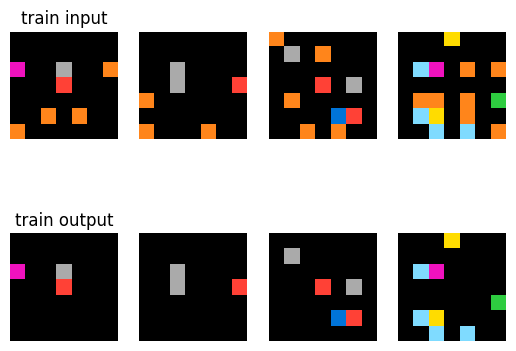

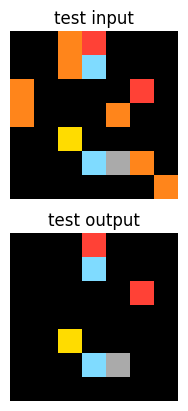

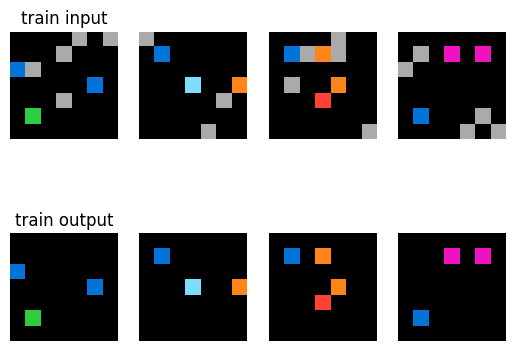

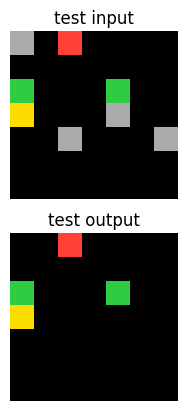

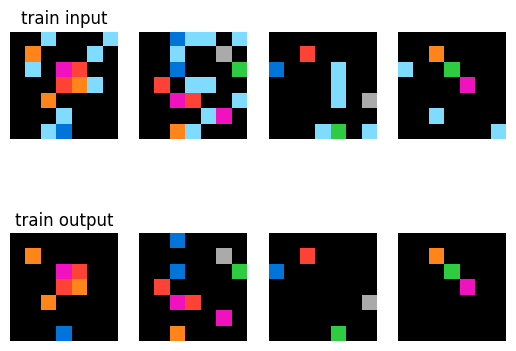

Creating color_change riddles...


100%|██████████| 100/100 [00:01<00:00, 58.55it/s]


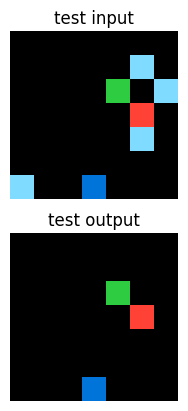

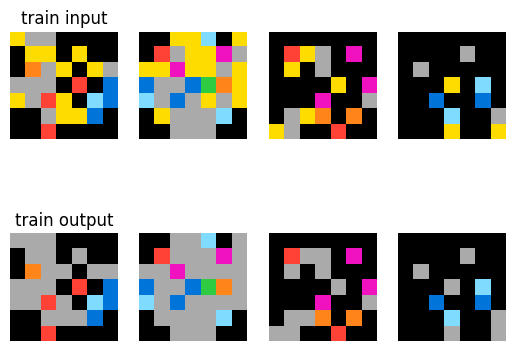

  2%|▏         | 2/100 [00:00<00:25,  3.89it/s]

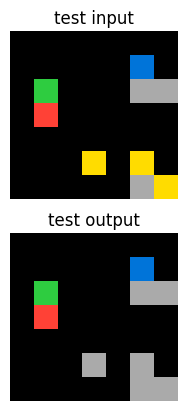

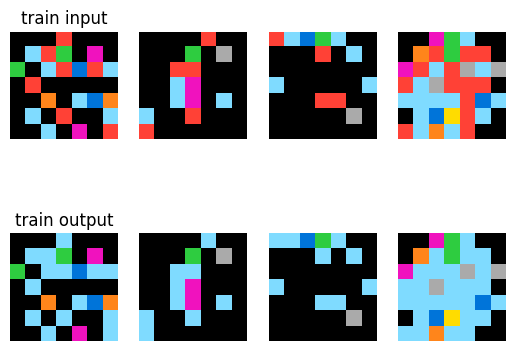

  3%|▎         | 3/100 [00:00<00:31,  3.11it/s]

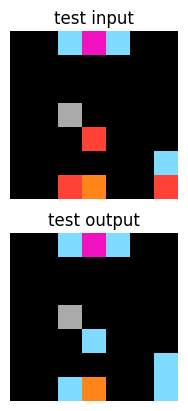

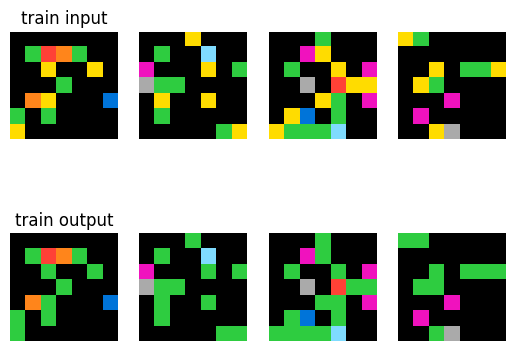

 85%|████████▌ | 85/100 [00:02<00:00, 86.40it/s]

Creating combined_pr_cc riddles...


100%|██████████| 100/100 [00:02<00:00, 45.31it/s]


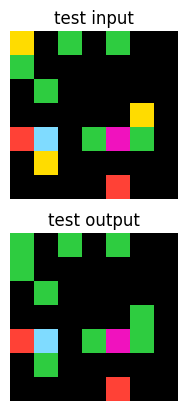

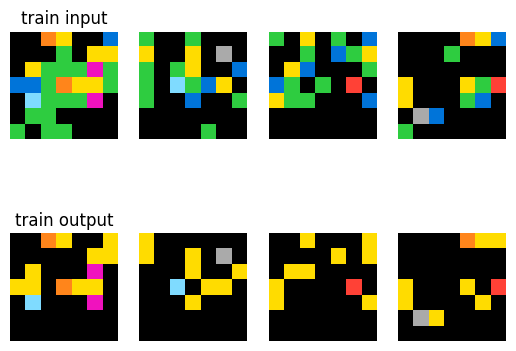

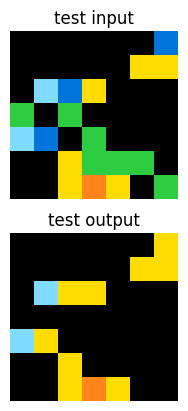

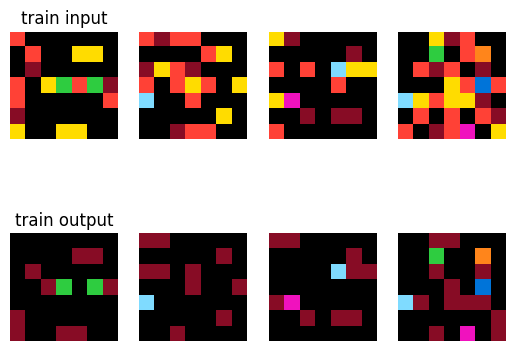

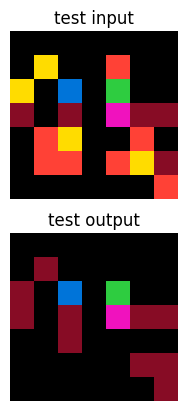

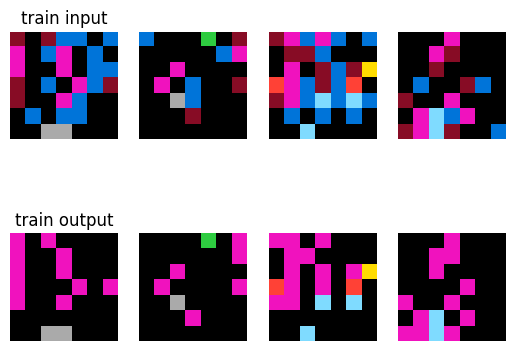

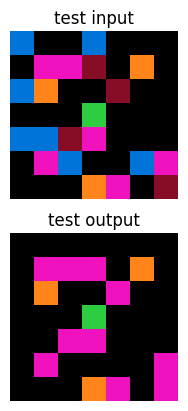

In [20]:
# import library for a progress indicator
from tqdm import tqdm

riddle_creation_functions = [create_pixel_removal_riddle, create_color_change_riddle, create_combined_riddle]
riddle_labels = ["pixel_removal", "color_change", "combined_pr_cc"]
rows = np.random.randint(5,31) if grid_size_height == -1 else grid_size_height
cols = np.random.randint(5,31) if grid_size_width == -1 else grid_size_width

for i in range(len(riddle_creation_functions)):
    riddle_creation_function= riddle_creation_functions[i]
    plot_count = 0
    print(f"Creating {riddle_labels[i]} riddles...")
    # init progress bar
    pbar = tqdm(total=dataset_size)

    for c in range(dataset_size):
        number_test_items = np.random.randint(3,7) if meta_trn_size==0 else meta_trn_size
        input_grids, output_grids, params = riddle_creation_function(number_test_items, rows, cols, min_num_colors_per_task)
        pbar.update(1)

        # set the train and test data; train is all but the last item, test is the last item
        train_input_grids = input_grids[:-1]
        train_output_grids = output_grids[:-1]
        test_input_grids = input_grids[-1:]
        test_output_grids = output_grids[-1:]

        json_obj = {}
        json_obj['train'] = []
        json_obj['test'] = []
        # train
        for io_pair in range(len(train_input_grids)):
            a = {
                'input': train_input_grids[io_pair].tolist(),
                'output': train_output_grids[io_pair].tolist()
            }
            json_obj['train'].append(a)

        a = {'input': test_input_grids[0].tolist(),
                'output': test_output_grids[0].tolist()    }
        json_obj['test'].append(a)
        if not os.path.exists(dataset_folder):
            os.makedirs(dataset_folder)
        output_folder = os.path.join(dataset_folder, riddle_labels[i])
        # verify folder exists ./dungeon_dataset/
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)
        #make a new filename that is 8 characters long and represents a random hex number
        # characters betwee 0-9 and a-f
        string = '0123456789abcdef'
        filename = ''.join(random.choice(string) for t in range(8)) + '.json'
        # write the json object to a file
        with open(os.path.join(output_folder, filename), 'w') as outfile:
            json.dump(json_obj, outfile)

        # plot the grids next to each other input in the first row and output in the second row
        if plot_count < plot_items:
            fig, axs = plt.subplots(2, len(train_input_grids))
            title = f"train input"
            axs[0][0].set_title(title)
            title2 = f"train output"
            axs[1][0].set_title(title2)
            for r in range(len(train_input_grids)):
                axs[0][r].axis('off')
                axs[1][r].axis('off')
                axs[0][r].imshow(train_input_grids[r], cmap=cmap_values, norm=norm, origin='lower')
                axs[1][r].imshow(train_output_grids[r], cmap=cmap_values, norm=norm, origin='lower')
            plt.show()
            # plot test items
            fig, axs = plt.subplots(2, 1)
            title = f"test input"
            axs[0].set_title(title)
            axs[0].axis('off')
            title2 = f"test output"
            axs[1].set_title(title2)
            axs[1].axis('off')
            axs[0].imshow(test_input_grids[0], label="test input", cmap=cmap_values, norm=norm, origin='lower')
            axs[1].imshow(test_output_grids[0], label="test output", cmap=cmap_values, norm=norm, origin='lower')
            plot_count += 1

    # dataset generated